# Ансамбли моделей
## Предисловие
Как Вы уже знаете, модели МО можно использовать не только "как есть", но ещё и строить разнообразные надстройки над ними. Хорошей идеей такой надстройки было и остаётся объединение моделей в ансамбль.

Сама суть ансамблей заключается в том, чтобы объединить предсказания стандартных моделей для повышения обощающей способности или надёжности ансамбля перед одиночным стандартным методом МО.

Ансамбли делятся на два типа:

- Голосующие (или усредняющие) - смысл их заключается в том, чтобы сначала обучить независимые друг от друга модели, а затем голосованием этих моделей выбирать предсказание (или усреднять предсказания по всем моделям, зависит от задачи). Обычно, качество предсказания у ансамблей лучше потому, что у них понижена дисперсия.

    Примеры: [Бэггинг](https://scikit-learn.org/stable/modules/ensemble.html#bagging), [Случайный лес](https://scikit-learn.org/stable/modules/ensemble.html#forest)

- Бустинг-ансамбли - последовательности стандартных моделей, построенные так, чтобы каждая последующая добавленная и натренированная модель каким-то образом исправляла ошибки всей предшествующей ей последовательности моделей. "Объединение слабых моделей даёт сильную модель".

    Примеры: [AdaBoost](https://scikit-learn.org/stable/modules/ensemble.html#adaboost), [Градиентный бустинг](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting)

Полная [документация](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble) по доступным в sklearn ансамблям.
[Урок](https://habr.com/ru/company/ods/blog/327250/) про бустинг из курса хабра.
https://github.com/rushter/MLAlgorithms/blob/master/mla/ensemble/gbm.py


## Задача
На этом воркшопе мы будем реализовывать алгоритм градиентного бустинга. Напомню, что в общем смысле бустинг заключается в том, чтобы тренировать каждую последующую модель так, чтобы она исправляла ошибки предыдущих.

Прежде чем мы приступим к реализации, давайте вспомним, как он устроен:
Краткое описание [оригинального алгоритма](https://statweb.stanford.edu/~jhf/ftp/stobst.pdf) (который придумал Фридман):
Для работы алгоритма помимо данных нужно подать:
1. количество итераций $M \in \mathbb{N}$;
2. функцию потерь $L(y,f)$, где $y$ - истинные значения, $f$ - полученная аппроксимация искомой функции (в данном случае это будет не функция, а просто предсказанные значения).
Важно, чтобы функция потерь была дифференцируемой по $f$;
3. базовая модель, на основе которой мы будем делать бустинг - в данном воркшопе мы воспользуемся деревьями решений;
4. Начальное приближение $f_0(x)$ - чаще всего для этого используют некую константу.

**Сам алгоритм:**
1. Задаём начальное приближение функции $f(x) = f_0(x)$ константой - в данном случае можно выбрать ноль, среднее по столбцу с целевым признаком или что-нибудь ещё.
2. Далее итеративно $t$ от 1 до $M$: 
    1. Считаем остатки как $\large r_{t} = -\left[\frac{\partial L(y, f(x))}{\partial f(x)}\right]_{f(x)=\hat{f}(x)}$
    2. Обучаем ещё одну базовую модель $h_t(x)$, при этом нецелевыми признаками у нас будет $x$, а в качестве целевого будем использовать остатки $r_t$, полученные на текущем шаге
    3. Найти оптимальный коэффициент $\rho_t = \underset{\rho}{\arg\min} \ L(y, \hat{f}(x) + \rho \cdot h(x))$ 
    4. обновить текущее приближение $\hat{f}(x) \leftarrow \hat{f}(x) + \hat{f}_i(x)$, где $\hat{f}_i(x) = \rho_t \cdot h_t(x)$
3. Собрать все полученные базовые алгоритмы в модель $\hat{f}(x) = \sum_{i = 0}^M \hat{f_i}(x)$

**Функции потерь:**
- $L(y, f) = (y - f)^2$ - L2-loss. Используйте его если считаете, что у модели нет никаких дополнительных требований к стабильности.
- $L(y, f) = |y - f|$ - L1-loss. Применять при требованиях к стабильности модели. Из минусов можно выделить то, что её немного сложнее дифференцировать (придётся искать производные на разных кусках)
- $\begin{equation} L(y, f) =\left\{ \begin{array}{@{}ll@{}} (1 - \alpha) \cdot |y - f|, & \text{if}\ y-f \leq 0 \\ \alpha \cdot |y - f|, & \text{if}\ y-f >0 \end{array}\right. \end{equation}, \alpha \in (0,1)$ - Lq-loss. Применять при наличии особых требований к модели, например, когда нам нужно восстановить не среднее и не медиану условного распределения $(y|x)$, а какую-нибудь квантиль. Штрафует наблюдения, попадающие выше $\alpha$-той квантили.

**Замечание:**
1. коэффициенты $\rho_i$ искать не обязательно, их можно считать равными единице
2. функций потерь для регрессии бывает 3 вида, Вам достаточно реализовать хотя бы одну из них (конечно, будет здорово, если вы реализуете их все) и посчитать для неё градиент, тоже в виде функции.

## Реализация алгоритма

Как обычно, сначала импортируем всё, что нам нужно.

In [89]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor

Теперь реализуйте функции потерь. Как я писал ранее, достаточно реализовать L2 loss или одну любую другую. Остальные - как дополнительное задание. Описания даны выше.

In [90]:
def l2_loss(y_real, y_predicted):
    return (y_real - y_predicted)**2

def l2_loss_gradient(y_real, y_predicted):
    return -1*(y_real - y_predicted)

def l1_loss(y_real, y_predicted):
    return abs(y_real - y_predicted)

def l1_loss_gradient(y_real, y_predicted):
    return np.gradient(l1_loss(y_real, y_predicted))

def lq_loss(y_real, y_predicted):
    if y <= 0:
        return (1 - a)*abs(y_real - y_predicted)
    else:
        return a * abs(y_real - y_predicted)

def lq_loss_gradient(y_real, y_predicted):
    return np.gradient(lq_loss(y_real, y_predicted))

Здесь мы просто упакуем функции в словарь, чтобы можно было передавать имя функции в алгоритм строкой.

In [91]:
losses = {
    'l2': (l2_loss, l2_loss_gradient),
    'l1': (l1_loss, l1_loss_gradient),
    'lq': (lq_loss, lq_loss_gradient),
}

### Теперь приступим к реализации самого алгоритма. 

**Описание полей класса:**

- `GradientTreeBoosting.estimators` - список, в котором мы будем хранить обученные деревья;
- `GradientTreeBoosting.tree_kwargs` - параметры конструктора для деревьев, такие как глубина дерева, max features, и т.д. Подробнее в [документации](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor);
- `GradientTreeBoosting.iteration` - $M$ из формул выше - количество итераций бустинга, и, одновременно, количество моделей, которые мы построим и объединим в ансамбль в результате бустинга;
- `GradientTreeBoosting.loss` - функция потерь;
- `GradientTreeBoosting.loss_grad` - градиент этой функции потерь.

Методы `fit` и `predict` с таким же назначением, как мы и раньше писали.

В методе `fit` Вам надо будет строить деревья, не забудьте передать им `tree_kwards` в качестве параметров конструктора. 

Обратите внимание, что по-умолчанию в качестве функции потерь указан l2-loss. Если вы его не реализовали, то измените на что-нибудь другое(или каждый раз указывайте явно или напишите try-except-блок).

In [92]:
class GradientTreeBoosting:
    def __init__(self, loss='l2', iterations=10, **tree_kwargs):
        self.estimators = []
        self.tree_kwargs = tree_kwargs
        self.iterations = iterations
        self.loss, self.loss_grad = losses.get(loss)
        
    def fit(self, x, y):
        f = 0
        for i in range(self.iterations):
            r = -self.loss_grad(y, f)
            h = DecisionTreeRegressor(**self.tree_kwargs)
            h.fit(x, r)
            f += h.predict(x)
            self.estimators.append(h)        
        
    def predict(self, x):
        res = np.zeros(x.shape[0])
        for estimator in self.estimators:
            res += estimator.predict(x)
        return res

### Проверка на игрушечном примере

Сгенерируем выборку на основе косинуса и проверим, на сколько хорошо бустинг деревьев справится с этой задачей. Сравнивать будем с обычным деревом с такими же параметрами.

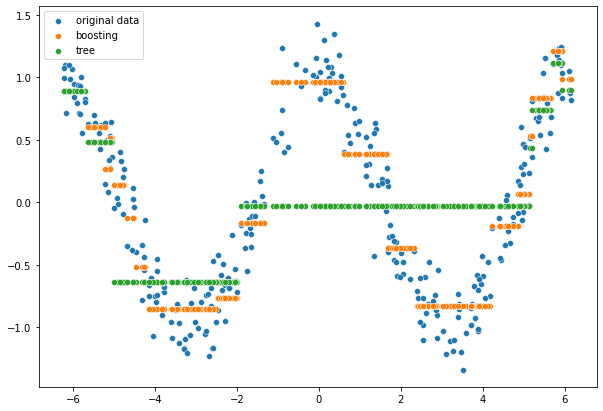

In [93]:
# генерируем данные
np.random.seed(42)
x = np.random.uniform(low=-2*np.math.pi, high=2*np.math.pi, size=(300))
y = np.cos(x) + np.random.randn(300) * 0.2

# обучаем обычное дерево глубины 3
tree = DecisionTreeRegressor(max_depth=3, random_state=42)
tree.fit(x.reshape(-1, 1), y)

# обучаем наш бустинг-ансамбль
clf = GradientTreeBoosting(iterations=3, max_depth=3, random_state=42)
clf.fit(x.reshape(-1, 1), y)

# визуализация
plt.figure(figsize=(10,7))
sns.scatterplot(x=x, y=y, label='original data')
sns.scatterplot(x=x, y=clf.predict(x.reshape(-1, 1)), label='boosting')
sns.scatterplot(x=x, y=tree.predict(x.reshape(-1, 1)), label='tree')

### Бустинг на практике: прогнозирование оттока пользователей из мобильной сети

Будем решать задачу классификации (sic!), предсказывая, уйдёт ли пользователь мобильной сети или нет.
Взято [отсюда](https://www.kaggle.com/mnassrib/telecom-churn-datasets).

Данные и их типы: 
- State: string
- Account length: integer 
- Area code: integer
- International plan: string
- Voice mail plan: string
- Number vmail messages: integer
- Total day minutes: double
- Total day calls: integer
- Total day charge: double
- Total eve minutes: double
- Total eve calls: integer
- Total eve charge: double
- Total night minutes: double
- Total night calls: integer
- Total night charge: double
- Total intl minutes: double
- Total intl calls: integer
- Total intl charge: double
- Customer service calls: integer
- Churn: string - целевой признак - уйдёт или нет (на самом деле pandas понимает его как булев)

Предсказывать будем логиты, то есть вероятность того, что клиент уйдёт, и на основе её уже делать прогноз, уйдёт ли он на самом деле или нет.

Вам предстоит самостоятельно провести эксперимент. Сравните качество нашей бустинг модели с обычными методами МО (вспомните и подумайте, какие лучше).

В качестве метрики качества используйте `f1_score` (а ещё лучше, `classification_report`).

#### Загрузите данные и предобработайте их.

Разбейте данные на тренировочную и тестовую подвыборки.

Поскольку деревья из sklearn не поддерживают категориальные признаки Вам придётся решить эту проблему - удалить их или обработать известными нам способами (one-hot-encoding, счётчики и тп).

В описании к датасету предполагалось использовать больший датасет(churn-bigml-80.csv) для обучения, а меньший(churn-bigml-20.csv) для проверки. 

In [94]:
train = pd.read_csv('/home/rimsky/Projects/ml-solutions/ml_course/data/churn-bigml-80.csv')
test = pd.read_csv('/home/rimsky/Projects/ml-solutions/ml_course/data/churn-bigml-20.csv')
print(train.shape)
print(test.shape)

(2666, 20)
(667, 20)


In [95]:
train.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [96]:
test.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False


In [97]:
cols = ['International plan', 'Voice mail plan']

for col in cols:
    tmp = train[col].copy()
    tmp[tmp == 'Yes'] = 1
    tmp[tmp == 'No'] = 0
    train[col] = tmp
    train[col] = train[col].astype('int')
train

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,SC,79,415,0,0,0,134.7,98,22.90,189.7,68,16.12,221.4,128,9.96,11.8,5,3.19,2,False
2662,AZ,192,415,0,1,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
2663,WV,68,415,0,0,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
2664,RI,28,510,0,0,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False


In [98]:
train.dtypes

State                      object
Account length              int64
Area code                   int64
International plan          int64
Voice mail plan             int64
Number vmail messages       int64
Total day minutes         float64
Total day calls             int64
Total day charge          float64
Total eve minutes         float64
Total eve calls             int64
Total eve charge          float64
Total night minutes       float64
Total night calls           int64
Total night charge        float64
Total intl minutes        float64
Total intl calls            int64
Total intl charge         float64
Customer service calls      int64
Churn                        bool
dtype: object

In [99]:
train['Churn'] = train['Churn'].astype('int')

In [100]:
train = pd.get_dummies(train)
train

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,...,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,128,415,0,1,25,265.1,110,45.07,197.4,99,...,0,0,0,0,0,0,0,0,0,0
1,107,415,0,1,26,161.6,123,27.47,195.5,103,...,0,0,0,0,0,0,0,0,0,0
2,137,415,0,0,0,243.4,114,41.38,121.2,110,...,0,0,0,0,0,0,0,0,0,0
3,84,408,1,0,0,299.4,71,50.90,61.9,88,...,0,0,0,0,0,0,0,0,0,0
4,75,415,1,0,0,166.7,113,28.34,148.3,122,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,79,415,0,0,0,134.7,98,22.90,189.7,68,...,0,0,0,0,0,0,0,0,0,0
2662,192,415,0,1,36,156.2,77,26.55,215.5,126,...,0,0,0,0,0,0,0,0,0,0
2663,68,415,0,0,0,231.1,57,39.29,153.4,55,...,0,0,0,0,0,0,0,0,1,0
2664,28,510,0,0,0,180.8,109,30.74,288.8,58,...,0,0,0,0,0,0,0,0,0,0


In [101]:
for col in cols:
    tmp = test[col].copy()
    tmp[tmp == 'Yes'] = 1
    tmp[tmp == 'No'] = 0
    test[col] = tmp
    test[col] = test[col].astype('int')
test

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,0,0,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,0,0,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,0,0,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,SC,111,415,0,0,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,HI,49,510,0,0,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,WI,114,415,0,1,26,137.1,88,23.31,155.7,125,13.23,247.6,94,11.14,11.5,7,3.11,2,False
663,AL,106,408,0,1,29,83.6,131,14.21,203.9,131,17.33,229.5,73,10.33,8.1,3,2.19,1,False
664,VT,60,415,0,0,0,193.9,118,32.96,85.0,110,7.23,210.1,134,9.45,13.2,8,3.56,3,False
665,WV,159,415,0,0,0,169.8,114,28.87,197.7,105,16.80,193.7,82,8.72,11.6,4,3.13,1,False


In [102]:
test['Churn'] = test['Churn'].astype('int')

In [103]:
test = pd.get_dummies(test)
test

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,...,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,117,408,0,0,0,184.5,97,31.37,351.6,80,...,0,0,0,0,0,0,0,0,0,0
1,65,415,0,0,0,129.1,137,21.95,228.5,83,...,0,0,0,0,0,0,0,0,0,0
2,161,415,0,0,0,332.9,67,56.59,317.8,97,...,0,0,0,0,0,0,0,0,0,0
3,111,415,0,0,0,110.4,103,18.77,137.3,102,...,0,0,0,0,0,0,0,0,0,0
4,49,510,0,0,0,119.3,117,20.28,215.1,109,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,114,415,0,1,26,137.1,88,23.31,155.7,125,...,0,0,0,0,0,0,0,1,0,0
663,106,408,0,1,29,83.6,131,14.21,203.9,131,...,0,0,0,0,0,0,0,0,0,0
664,60,415,0,0,0,193.9,118,32.96,85.0,110,...,0,0,0,0,0,1,0,0,0,0
665,159,415,0,0,0,169.8,114,28.87,197.7,105,...,0,0,0,0,0,0,0,0,1,0


In [104]:
X_train = train.drop(columns=['Churn'])
X_test = test.drop(columns=['Churn'])
y_train = train['Churn']
y_test = test['Churn']

In [105]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [114]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

 Здесь я немного помогу Вам. Функция test_qual позволяет проверить качество классификации без лишних телодвижений. Воспользуйтесь ей (если хотите, можете модифицировать как Вам удобно). В исходном виде она не подойдёт для финальной проверки (на разных датасетах), но вы можете сделать промежуточные выводы на её основе.

In [107]:
def decide_class(logits, threshold=0.5):
    res = np.zeros(logits.shape[0])
    res[logits >= threshold] = 1
    return res

def test_qual(model, X_train, X_test, y_train, y_test, threshold=0.5):
    from sklearn.metrics import classification_report
    from sklearn.model_selection import train_test_split

    model.fit(X_train, y_train)
    test_logits = model.predict(X_test)
    y_pred = decide_class(test_logits, threshold=threshold)

    # print(accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [117]:
print(test_qual(DecisionTreeRegressor(max_depth=3, random_state=42), X_train, X_test, y_train, y_test))
print(test_qual(RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42), X_train, X_test, y_train, y_test))
print(test_qual(GradientTreeBoosting(iterations=10, max_depth=3, random_state=42), X_train, X_test, y_train, y_test))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       572
           1       0.86      0.52      0.64        95

    accuracy                           0.92       667
   macro avg       0.89      0.75      0.80       667
weighted avg       0.92      0.92      0.91       667

None
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       572
           1       0.83      0.61      0.70        95

    accuracy                           0.93       667
   macro avg       0.88      0.79      0.83       667
weighted avg       0.92      0.93      0.92       667

None
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       572
           1       0.83      0.77      0.80        95

    accuracy                           0.94       667
   macro avg       0.90      0.87      0.88       667
weighted avg       0.94      0.94      0.94       667

None
